In [1]:
import sqlite3
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
conn = sqlite3.connect('words.db')
cur = conn.cursor()

## Граф совпадения падежей

In [3]:
cases = {'nomn', 'gent', 'datv', 'accs', 'ablt', 'loct', 'voct', 'gen2', 'acc2','loc2'}
cases_l = sorted(list(cases))

In [4]:
def get_case_lines(left):
    st = '''
    select pos_tag_lemma.word, GROUP_CONCAT(tag, '+')
    from pos_tag_lemma
    join main on main.word = pos_tag_lemma.word
    where pos_tag_lemma.pos = 'NOUN'
    group by pos_tag_lemma.word
    order by freq DESC
    limit ''' + str(left) + ', ' + str(1000)
    cur.execute(st)
    lines = cur.fetchall()
    return lines

In [5]:
def make_words_and_cases(lines):
    words_and_cases = {}
    for word in lines:
        words_and_cases[word[0]] = []
        for tag in word[1].split('+'):
            words_and_cases[word[0]].append(list(cases&set(tag.split()))[0])
        words_and_cases[word[0]] = sorted(list(set(words_and_cases[word[0]])))
    return words_and_cases

In [6]:
def make_half_matrix(l):
    matrix = {}
    for i in range(len(l)):
        matrix[l[i]] = {}
        for j in range(i, len(l)):
            matrix[l[i]][l[j]] = 0
    return matrix

In [7]:
def fill_half_matrix(matrix, d):
    for word in d.keys():
        case = d[word]
        if len(case) > 1:
            for i in range(len(case)):
                first = case[i]
                for j in range(i+1, len(case)):
                    second = case[j]
                    matrix[first][second] += 1
        else:
            first = case[0]
            matrix[first][first] += 1
    return matrix

In [8]:
def make_filled_matrix(l, d):
    m = make_half_matrix(l)
    matrix = fill_half_matrix(m, d)
    return matrix

In [9]:
def fill_graph(cases_matrix, q):
    G = nx.Graph()
    for c1 in cases_matrix.keys():
        for c2 in cases_matrix[c1]:
            w = cases_matrix[c1][c2]
            if w != 0:
                G.add_edge(c1, c2, weight = q*w)
    return G

In [10]:
def draw_graph(G, left, right, name):
    pos = nx.circular_layout(G)
    plt.figure(figsize=(10, 10))


    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color = '#7986CB')
    
    for edge_set in list(G.edges.items()):
        edge = edge_set[0]
        weight = edge_set[1]['weight']
        width = weight
        nx.draw_networkx_edges(G, pos, edgelist=[edge,], edge_color = '#81C784', width=width)
        
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.axis('off')
    title = name + str(left) + '-' + str(right)

    plt.title(title)
    plt.show()

In [11]:
def make_case_pompom(left, right):
    lines = get_case_lines(left)
    words_and_cases = make_words_and_cases(lines)
    cases_matrix = make_filled_matrix(cases_l, words_and_cases)
    G = fill_graph(cases_matrix, 0.05)
    draw_graph(G, left, right, 'Падежи в словоформах ')

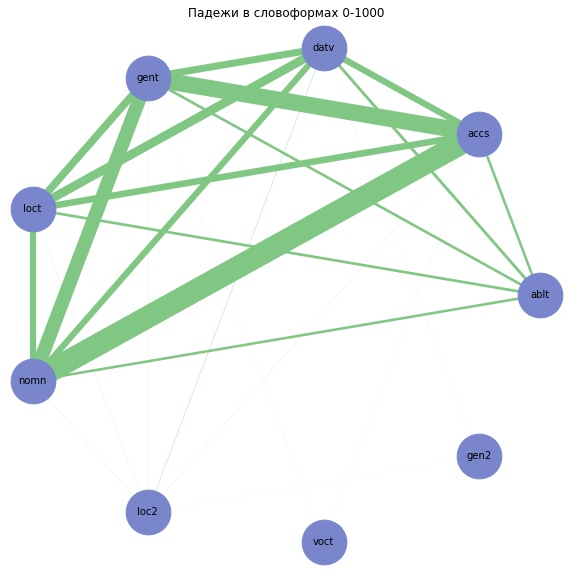

In [12]:
make_case_pompom(0, 1000)

## Падежи для неоднозначности по лемме

In [13]:
def get_case_lines_amb_lem(right):
    st = '''
    select pos_tag_lemma.word, GROUP_CONCAT(tag, '+')
    from pos_tag_lemma
    join main on main.word = pos_tag_lemma.word
    where pos_tag_lemma.pos = 'NOUN' and type = 'неоднозначно по лемме'
    group by pos_tag_lemma.word
    order by freq DESC
    limit ''' + str(0) + ', ' + str(right)
    cur.execute(st)
    lines = cur.fetchall()
    return lines

In [14]:
def make_amb_lem_pompom(left, right):
    lines = get_case_lines_amb_lem(right)
    words_and_cases = make_words_and_cases(lines)
    cases_matrix = make_filled_matrix(cases_l, words_and_cases)
    G = fill_graph(cases_matrix, 0.05)
    draw_graph(G, left, right, 'Падежи в словоформах ')

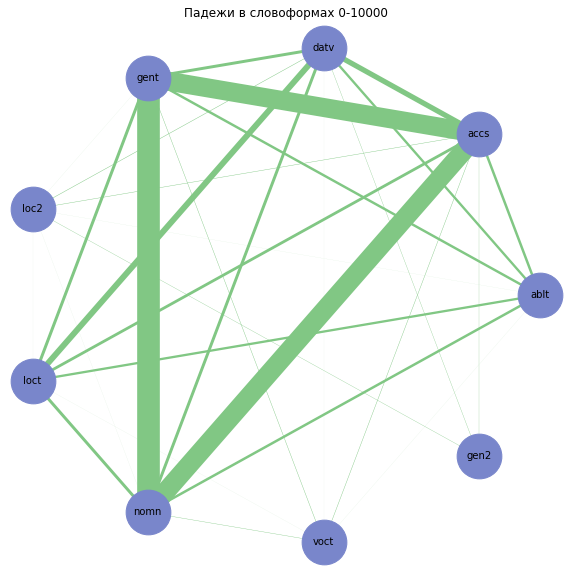

In [15]:
make_amb_lem_pompom(0, 10000)

## Падежи для неоднозначности по параметрам

In [16]:
def get_case_lines_amb_par(right):
    st = '''
    select pos_tag_lemma.word, GROUP_CONCAT(tag, '+')
    from pos_tag_lemma
    join main on main.word = pos_tag_lemma.word
    where pos_tag_lemma.pos = 'NOUN' and type = 'неоднозначно по параметрам'
    group by pos_tag_lemma.word
    order by freq DESC
    limit ''' + str(0) + ', ' + str(right)
    cur.execute(st)
    lines = cur.fetchall()
    return lines

In [17]:
def make_amb_par_pompom(left, right):
    lines = get_case_lines_amb_par(right)
    words_and_cases = make_words_and_cases(lines)
    cases_matrix = make_filled_matrix(cases_l, words_and_cases)
    G = fill_graph(cases_matrix, 0.05)
    draw_graph(G, left, right, 'Падежи в словоформах ')

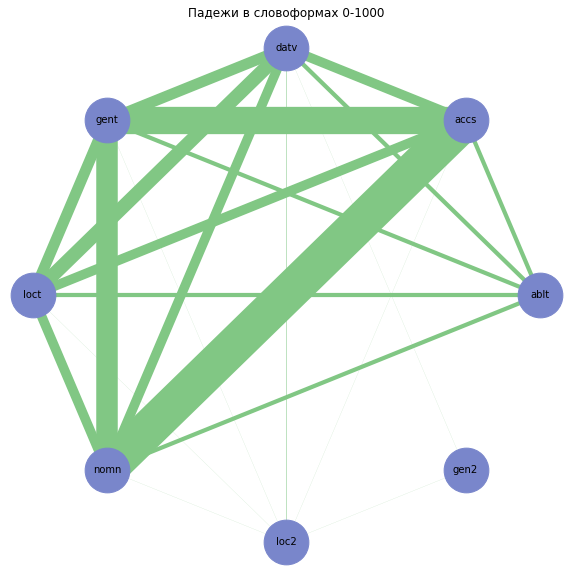

In [18]:
make_amb_par_pompom(0, 1000)

## Граф частей речи

In [19]:
list_of_pos = ['NOUN', 'ADJF', 'ADJS', 'COMP', 'VERB', 'INFN', 'PRTF', 'PRTS', 'GRND', 'NUMR', 'ADVB', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ']
list_of_pos = sorted(list_of_pos)

In [20]:
def get_pos_lines(right):
    st = '''select pos_tag_lemma.word, GROUP_CONCAT(pos, ', ')
            from pos_tag_lemma
            join main on main.word = pos_tag_lemma.word
            where pos_tag_lemma.pos is not null
            group by pos_tag_lemma.word
            order by freq DESC
            limit ''' + str(0) + ', ' + str(right)
    cur.execute(st)
    lines = cur.fetchall()
    return lines

In [21]:
def make_word_pos_d(lines):
    word_pos_d = {}
    for line in lines:
        word_pos_d[line[0]] = sorted(list(set(line[1].split(', '))))
        
    return word_pos_d

In [22]:
def make_pos_pompom(left, right):
    lines = get_pos_lines(right)
    word_pos_d = make_word_pos_d(lines)
    pos_matrix = make_filled_matrix(list_of_pos, word_pos_d)
    G = fill_graph(pos_matrix, 0.2)
    draw_graph(G, left, right, 'Части речи в словоформах ')

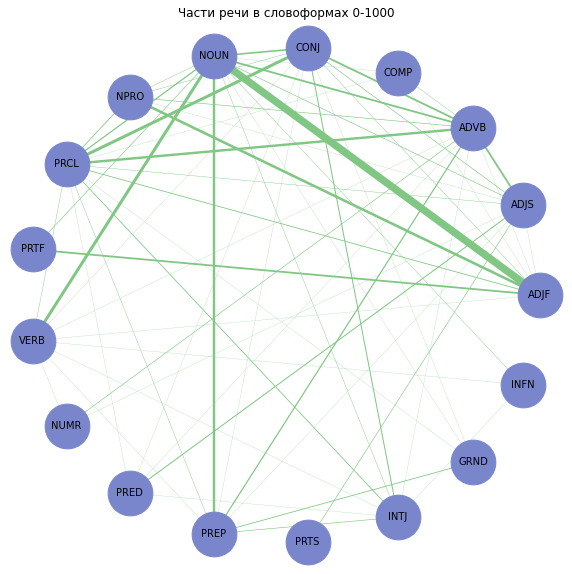

In [23]:
make_pos_pompom(0, 1000)